# Расчет юнит экономики склада оборудования

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np

# Указываем путь к файлу шрифта TT Commons Regular
font_path = r"C:\Users\orine\Downloads\tt-commons\TT Commons Regular.otf"

# Добавляем шрифт в список доступных шрифтов
fm.fontManager.addfont(font_path)
# Устанавливаем моноширинный шрифт
mpl.rcParams["font.family"] = "TT Commons"
mpl.rcParams["font.style"] = "normal"
# Отключаем предупреждения
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 40)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("na_rep", "-")

### Стоимость хранения

Вычислим стоимость хранения (1 м3 в сутки) следующим образом: разделим средние месячные расходы на склад (аренда, обслуживание, ФОТ и.т.д.) на вместимость зоны хранения в м3, затем разделим на 30 дней.

In [288]:
# Важные значения:
# Уровень доли от оборота, выше которого траты на хранение считаются потерями.
loss_level = 0.015

# Количество дней, после которых ТМЦ становится неликвидным и расходы на него становятся потерями.
max_dead_days = 90

# ФОТ 2020 - 2023 (штат) в среднем составляет 4_300_000 в месяц.
# ФОТ 2024 (штат) в среднем составляет 8_000_000 в месяц.
# Затраты на аутсорс за все периоды в среднем составляют 2_000_000 в месяц.

fot = (4_300_000 * 12 * 4 + 8_000_000 * 9) / 57 + 2_000_000

# Затраты на содержание склада в среднем составляют 6_150_000 в месяц;
warehouse_cost = 6_150_000

# Вместимость зоны хранения склада 7326 м3;
warehouse_main_volume = 7326

# Вместимость мезонина 135 м3.
warehouse_mezo_volume = 135

total_volume = warehouse_main_volume + warehouse_mezo_volume
total_cost = warehouse_cost + fot

# Вычислим итоговую стоимость
volume_cost = total_cost / total_volume
cub_per_day = volume_cost / 30

print(f"Затраты на хранение 1 м3 в месяц составляют {volume_cost:.2f} руб.")
print(f"В день соответственно {cub_per_day:.2f} руб.")

Затраты на хранение 1 м3 в месяц составляют 1746.98 руб.
В день соответственно 58.23 руб.


### Объем ТМЦ

В учетной системе отсутствуют данные о ВГХ. Для усредненного вычисления объема ТМЦ был выбран следующий метод, основанный на предположении о том, что все занимаемые ячейки заполнены более чем на 80%. Это позволяет приблизительно оценить объем вложений следующим образом:
1. Делим объем каждой ячейки на количество разных ТМЦ в ее вложении;
2. Для каждой ТМЦ делим получившуюся долю на количество единиц в этой ячейке;
3. Для каждой ТМЦ находим наименьший объем на единицу хранения среди всех ячеек.

В этой схеме играет на руку миксованное хранение, где большинство ТМЦ хранится в нескольних ячейках и реальная заполненность склада на момент сбора данных составляет 85%.

## Источники данных

Все таблицы заранее подготовлены и преобразованы.

### Объем ТМЦ

Откроем таблицу с объемами номенклатур.

Структура таблицы:
- `unit_cost` - Стоимость одной единицы ТМЦ;
- `unit_id` - Код номенклатуры;

In [ ]:
volumes = pd.read_csv(
    r"data\prepared\unit_volume.csv", sep=";", decimal=","
)
volumes.unit_id = volumes.unit_id.astype("int64", errors="ignore")


volumes.head(2)

,unit_id,volume
0,643452526,2.69
1,643457781,2.69


### Стоимость ТМЦ

Таблица с стоимостью единиц составлена на основании данных из 1С - отчет "Движение и резерв оборудования" - вариант "Анализ УУ и БУ оборудования" - стоимость по бух учету.

Структура таблицы:
- `unit_cost` - Стоимость одной единицы ТМЦ;
- `unit_id` - Код номенклатуры;

In [ ]:
costs = pd.read_csv(
    r"data\prepared\unit_costs.csv", sep=";", decimal=","
)

costs.head(2)

,unit_id,unit_cost
0,643151803,152.14
1,643153192,136.51


### Профили

Объединим таблицы и составим профили номенклатур. Объединим внутренним соединением, так как данные из разных источников совпадают не полностью.

In [291]:
# Объединим таблицы
profiles = volumes.merge(costs, on="unit_id", how="inner")

# Приведем типы
profiles["unit_id"] = profiles["unit_id"].astype("int64")
profiles["volume"] = profiles["volume"].astype("float")
profiles["unit_cost"] = profiles["unit_cost"].astype("float")

# Посчитаем стоимость хранения в день
profiles["cost_per_day"] = profiles.volume * cub_per_day

profiles.head(2)

,unit_id,volume,unit_cost,cost_per_day
0,643489376,1.82,10108.33,106.22
1,643456865,1.82,10205.25,106.22


### Реквизиты ТМЦ

- `unit_art` - Артикул;
- `unit_name` - Наименование;
- `unit_brand` - Бренд.

In [ ]:
# Подключим таблицу с данными из справочника номенклатур
obor_data = pd.read_excel(r"data\raw\oborud_data.xlsx")

# Преобразуем таблицу (уберем шапку отчета и переименуем названия столбцов)
obor_data = obor_data.loc[6:].dropna(how="all", axis=1).reset_index(drop=True)
obor_data.columns = [
    "unit_id",
    "unit_art",
    "unit_name",
    "unit_brand",
    "unit_count",
    "total_price",
]

# Удалим дубликаты строк
obor_data = obor_data.sort_values(by="total_price", na_position="last").drop_duplicates(
    subset=["unit_id"], keep="first"
)

# Отфильтруем позиции которые есть в других таблицах
obor_data = obor_data[obor_data["unit_id"].isin(profiles["unit_id"])]
obor_data.set_index("unit_id", inplace=True)

obor_data.head(2)

,unit_art,unit_name,unit_brand,unit_count,total_price
unit_id,,,,,
643342014,SL-TO-210,"Держатель А4 белый, SL",SELA,1,4.38
643341361,SL-TO-140,"Держатель на короткой ножке белый, SL",SELA,26,11.90


### Остатки и обороты ТМЦ

Теперь добавим и отфильтруем подготовленную таблицу с оборотами запасов с 2016 года.
Таблица содержит данные оборотов по следующим складам: 
- Склад Оборудования в СПб
- Склад Уткина Заводь (оборудование)
- Сервис Логистика Спб
- Форстранс-Кубинская


Структура таблицы:
- `warehouse_id` - Название склада на котором зафиксирован документ движения;
- `unit_id` - Код номенклатуры;
- `date` -  Дата документа;
- `income` - Количество вход;
- `outcome` - Количество выход;
- `end_balance` - Конечный остаток;
- `not_valuable_send` - Тип движения: 1 - внутреннее, 0 - внешнее.

Признак типа движения был добавлен для того, чтобы отличить перемещения между складами временного хранения и Уткиной Заводью от отгрузок в розницу.

In [ ]:
turnover = pd.read_csv(r"data\prepared\turnover.csv", sep=",")
turnover["not_valuable_send"] = turnover["not_valuable_send"].astype("bool")

# Отфильтруем таблицу с оборотами, оставим только данные по имеющимся номенклатурам.
turnover = turnover[turnover["unit_id"].isin(profiles["unit_id"])]

turnover.head(2)

,warehouse_id,unit_id,date,income,outcome,end_balance,not_valuable_send
25252,Склад Уткина Заводь (оборудование),643526606,2024-08-16,0.00,1.00,1.00,False
25253,Склад Уткина Заводь (оборудование),643526606,2024-08-13,1.00,0.00,2.00,False


### Финальная таблица

Сведем данные с оборотами, добавив каждой операции информацию из таблицы с профилями о стоимости хранения в день, стоимости единицы ТМЦ и объем.

In [294]:
df = (
    turnover.merge(profiles, on="unit_id", how="left")
    .sort_values(by=["warehouse_id", "date", "unit_id"])
    .reset_index(drop=True)
)

# выведем пример движения по одной номенклатуре
df[df.unit_id == 643321156].head()

,warehouse_id,unit_id,date,income,outcome,end_balance,not_valuable_send,volume,unit_cost,cost_per_day
23123,Склад Оборудования в СПб,643321156,2019-02-13,694.80,0.00,694.80,False,0.03,5729.84,1.73
23162,Склад Оборудования в СПб,643321156,2019-02-14,0.00,28.08,630.36,False,0.03,5729.84,1.73
23163,Склад Оборудования в СПб,643321156,2019-02-14,0.00,36.36,658.44,False,0.03,5729.84,1.73
23297,Склад Оборудования в СПб,643321156,2019-02-15,0.00,27.00,603.36,False,0.03,5729.84,1.73
24502,Склад Оборудования в СПб,643321156,2019-03-18,0.00,6.84,596.52,False,0.03,5729.84,1.73


## Поиск аномалий

Проверим числовые данные таблицы `df` по дням.

### income

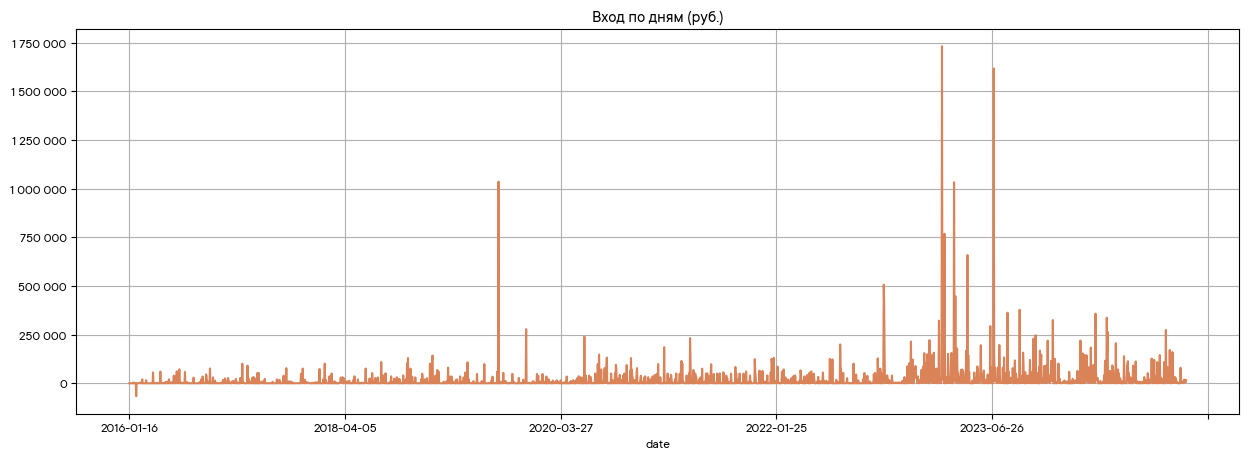

In [295]:
df.groupby("date")["income"].sum().plot(figsize=(15, 5), grid=True, color="#DA8359")
plt.title("Вход по дням (руб.)")
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.show()

На всем протяжении видны несколько пиков, в которых объем полученных единиц превышает 500000 за сутки, посмотрим что это были за позиции. Выведем топ 3 номенклатур, принятых складом в эти дни.

In [296]:
for i in df.groupby("date")["income"].sum().loc[lambda x: x > 500000].index:
    top_3 = (
        df[df["date"] == i]
        .groupby("unit_id")["income"]
        .sum()
        .sort_values(ascending=False)
        .head(3)
    )
    result = obor_data.loc[top_3.index].dropna(how="any")[["unit_art", "unit_name"]]
    print(i)
    display(result.join(top_3))

2019-08-30


,unit_art,unit_name,income
unit_id,,,
643340644,SL-TO-012,"Соединители для этикет пистолетов,SL",1000000.00
643342627,SL-TO-257,"Игла для датчиков Super Tack серый, SL",20800.00
643341188,SL-TO-115,"Крючок ЭП L200 хром, SL",5130.00


2022-10-12


,unit_art,unit_name,income
unit_id,,,
643328633,A-DG54-AM-B,Датчик антикражный Golf 54 гольф чёрный ракушка Акустомагнитный,244000.00
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,116000.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,116000.00


2023-03-02


,unit_art,unit_name,income
unit_id,,,
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,692200.00
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,692200.00
643328633,A-DG54-AM-B,Датчик антикражный Golf 54 гольф чёрный ракушка Акустомагнитный,276000.00


2023-03-08


,unit_art,unit_name,income
unit_id,,,
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,286000.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,286000.00
643328633,A-DG54-AM-B,Датчик антикражный Golf 54 гольф чёрный ракушка Акустомагнитный,156000.00


2023-03-30


,unit_art,unit_name,income
unit_id,,,
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,279000.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,279000.00
643438310,SL-KGBL.CN,Вешалка блузочная детская,138000.00


2023-04-30


,unit_art,unit_name,income
unit_id,,,
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,277100.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,277100.00
643328633,A-DG54-AM-B,Датчик антикражный Golf 54 гольф чёрный ракушка Акустомагнитный,50000.00


2023-06-30


,unit_art,unit_name,income
unit_id,,,
643340644,SL-TO-012,"Соединители для этикет пистолетов,SL",200000.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,169665.00
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,166800.00


С поступлениями все в порядке, эти позиции мелкоштучные.

### outcome

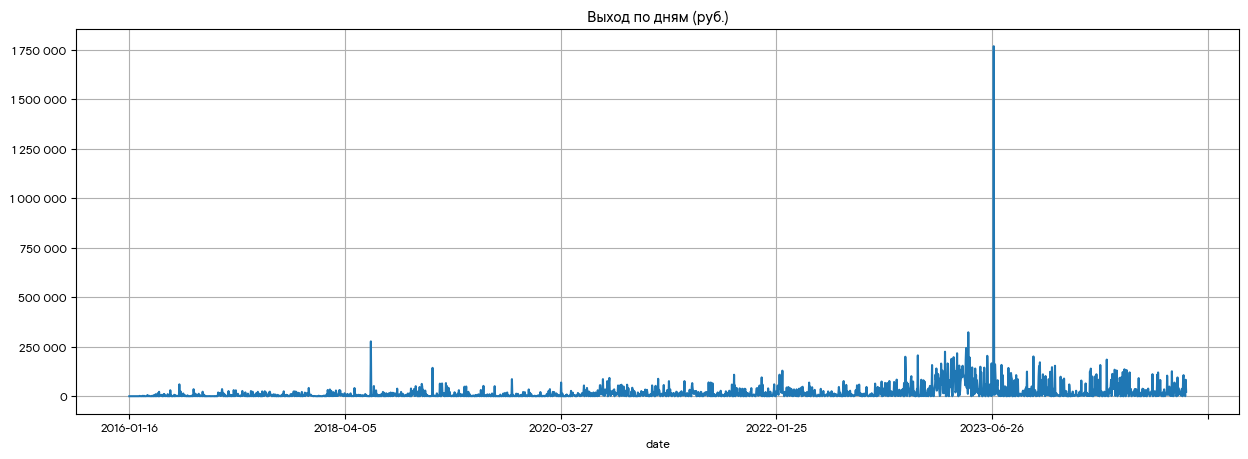

In [297]:
df.groupby("date")["outcome"].sum().plot(figsize=(15, 5), grid=True)
plt.title("Выход по дням (руб.)")
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.show()

In [298]:
for i in df.groupby("date")["outcome"].sum().loc[lambda x: x > 250000].index:
    top_3 = (
        df[df["date"] == i]
        .groupby("unit_id")["outcome"]
        .sum()
        .sort_values(ascending=False)
        .head(3)
    )
    result = obor_data[obor_data.index.isin(top_3.index)].dropna(how="any")[
        ["unit_art", "unit_name"]
    ]
    print(i)
    display(result.join(top_3))

2018-06-28


,unit_art,unit_name,outcome
unit_id,,,
643277366,A-DG-AM-B,Датчик антикражный Golf гольф чёрный ракушка Акустомагнитный,69620.00
643277463,A-TI15,Тросик петля игла 15см для противокражных датчиков,24400.00


2023-05-02


,unit_art,unit_name,outcome
unit_id,,,
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,63500.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,68700.00
643438310,SL-KGBL.CN,Вешалка блузочная детская,42700.00


2023-06-30


,unit_art,unit_name,outcome
unit_id,,,
643340644,SL-TO-012,"Соединители для этикет пистолетов,SL",205000.00
643277363,A-IG-DP,Игла гвоздь кнопка для датчика penciltag пальчикового,230800.00
643290962,A-DP-AM-W,Датчик антикражный Penciltag Белый пальчиковый без иголки Акустомагнитный,234165.00


Аналогично входу - мелкоштучная антикражка.

### volume и cost_per_day

Посмотрим на данные полученные по теоретическому вычислению объема ТМЦ. 

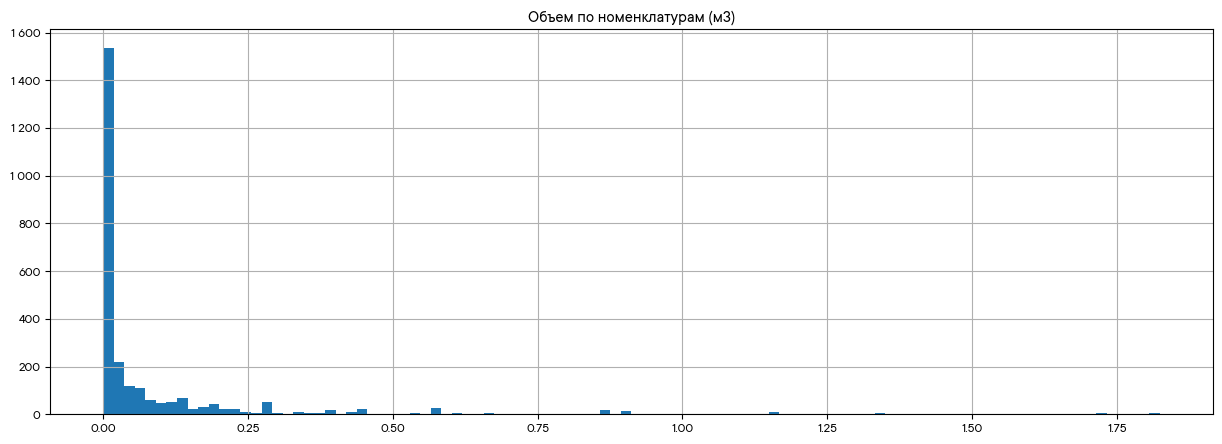

In [299]:
plt.figure(figsize=(15, 5))

(
    profiles.merge(obor_data, left_on="unit_id", right_index=True, how="left")
    .sort_values(by=["volume", "unit_cost"], ascending=True)["volume"]
    .hist(bins=100)
)
plt.title("Объем по номенклатурам (м3)")
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.show()

На гистограмме видно, что большинство оборудования занимает до 0.5 м3. Проверим список позиций больше этой величины на предмет не эффективного хранения или не заполненной ячейки.

In [300]:
print("Топ 20 самых больших позиций")

display(
    profiles.merge(obor_data, left_on="unit_id", right_index=True, how="left")
    .sort_values(by=["volume", "unit_cost"], ascending=False)[
        ["unit_id", "unit_name", "volume"]
    ]
    .loc[lambda row: row["volume"] > 0.5]
    .head(20)
)

print("Топ 20 самых маленьких позиций больше 0.5 м3")

display(
    profiles.merge(obor_data, left_on="unit_id", right_index=True, how="left")
    .sort_values(by=["volume", "unit_cost"], ascending=True)[
        ["unit_id", "unit_name", "volume"]
    ]
    .loc[lambda row: row["volume"] > 0.5]
    .head(20)
)

Топ 20 самых больших позиций


,unit_id,unit_name,volume
3,643333058,Диван бордовый в зону примерочных POL LR,1.82
2,643315858,Тумба 2х3 (L=1400мм),1.82
5,643466523,Стол офисный 1600мм х900мм белый ZR,1.82
1,643456865,Пуф 1350х600х500мм бирюзовый (Velvet lux),1.82
0,643489376,Тумба для принтера 770*460*750 белая,1.82
4,643447528,Вешало мобильное в кассовую зону,1.82
10,643303575,Форма архитект. ЕДИНОРОГ (полигональная) ОС,1.73
7,643431180,"Декоративная конструкция ""труба"" над манекеном h=1.3м LR",1.73
11,643503411,"Холодильник однокамерный Бирюса111 122,5x48x60,5см",1.73
8,643526701,Морозильная камера Hyundai CU1007 черный,1.73


Топ 20 самых маленьких позиций больше 0.5 м3


,unit_id,unit_name,volume
111,643502419,Вешало для одежды П-образное - 900х450х1300 мм,0.50
110,643452863,Труба с профилем подсветки 1800 мм LR,0.54
109,643364982,Накопитель для вешалок V2 RUS LR,0.54
107,643507176,Отпариватель Bort Comfort + Black Edition,0.54
108,643452019,"Светильник LED подвесной круг d-1000 (30W, 350mA, IP20, 4000 K White)",0.54
106,643500011,"Закасса прямая для 2-кассы, Blanco Marble V3 (Рикс) LR",0.54
104,643503414,Кронштейн приставной с отверстием 1000х500х1350 FA,0.54
103,643429629,Стремянка алюминиевая 3 ступени,0.55
102,643502301,Стремянка 5 ступеней ТД,0.55
48,643340736,"Корзина бельевая с пластиковым ящиком, 800х800х900 мм, SL",0.58


Проверим объем керамической плитки на наличие аномалий.

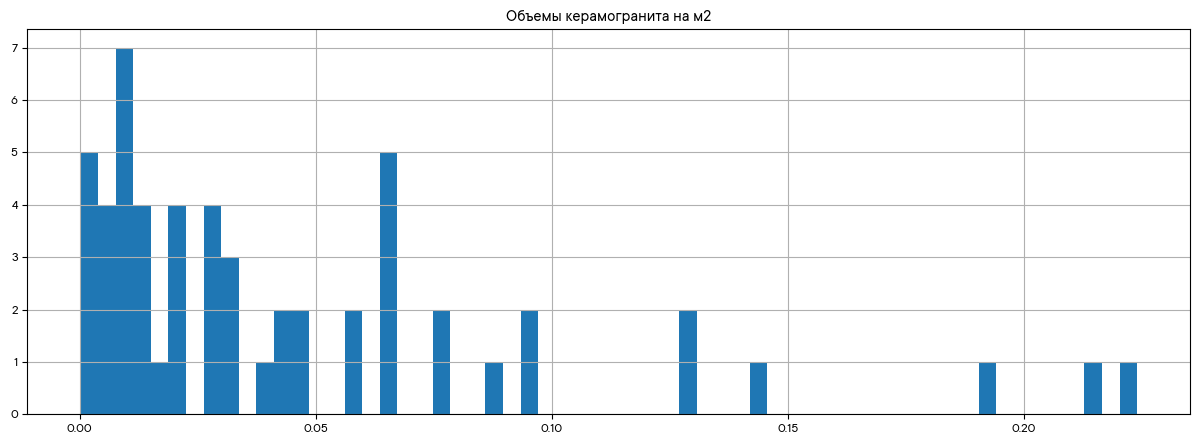

In [301]:
# Отфильтруем керамогранит и посмотрим его стандартный объем
ids = obor_data[obor_data["unit_name"].str.contains("ерам")][
    ["unit_brand", "unit_name"]
].index

granit = volumes[volumes.unit_id.isin([str(x) for x in ids])]

granit.hist(bins=60, figsize=(15, 5))
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.title("Объемы керамогранита на м2")
plt.show()

Объем 1 метра прлитки выше 0.1 м3 явная аномалия. Посмотрим на список:

In [302]:
granit_filtered = granit.loc[granit["volume"] > 0.1]
granit_filtered.unit_id = granit_filtered.unit_id.astype(int)
granit_filtered.merge(obor_data, left_on="unit_id", right_index=True, how="left")

,unit_id,volume,unit_art,unit_name,unit_brand,unit_count,total_price
693,643354190,0.22,LR-CBENS.RUS,Керамогранит черный эверест неро лаппатированный 1200х295 мм RUS LR,LOVE REPUBLIC,5.31,7964.05
716,643521889,0.22,LR-PZ-02.00-V1-4K,"Отвес на колесах, телескопический 1400мм с демпферами черный LR",LOVE REPUBLIC,4,21750
835,643415971,0.19,ZA-SM001,Керамогранит МИРАБО светлый серый 600*600*11мм,ZARINA,9,8967.16
996,643463659,0.14,ZA-TAGAN-02.12B,Керамическая плитка Taganay White 60*60 матовый ZR тон 12B,ZARINA,5.76,5030.38
1082,643431333,0.13,LR-NO-009.002,Столешница для стола из керамогранита 1800*900мм LR,LOVE REPUBLIC,7,86193.01
1086,643256251,0.13,LR-KGMR-K18,Керамогранит черный под мрамор 600*600,LOVE REPUBLIC,2.88,1806.23


За исключением "Отвес на колесах, телескопический" и "Столешница для стола из керамогранита" данные завышены. Исправим аномалии на медианное значение по керамике.

In [303]:
ids = granit.loc[granit["volume"] > 0.1]["unit_id"]
ids = ids[~ids.isin(["643521889", "643431333"])]

volumes[volumes.unit_id.isin(ids)] = granit.volume.median()

### unit_cost	

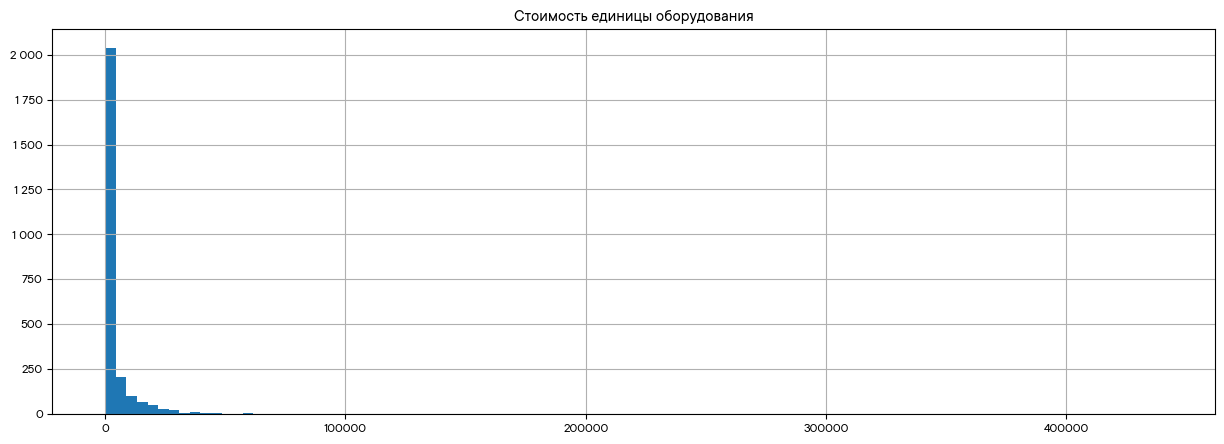

In [304]:
plt.figure(figsize=(15, 5))

costs_data = profiles.merge(
    obor_data, left_on="unit_id", right_index=True, how="left"
).sort_values(by=["volume", "unit_cost"], ascending=True)

costs_data["unit_cost"].hist(bins=100)

plt.title("Стоимость единицы оборудования")
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.show()

In [305]:
costs_data[costs_data["unit_cost"] > 200_000].sort_values(
    by="unit_cost", ascending=False
)

,unit_id,volume,unit_cost,cost_per_day,unit_art,unit_name,unit_brand,unit_count,total_price
289,643498749,0.21,440000.00,12.04,ID.KZ.001-05,Кассовый стол на 2 кассира 3000*730*1050 столешница Кварцит ID,МФГ,1,440000
367,643469459,0.16,340678.60,9.58,LR-FT-003.RIX,"Подиум для фокус точки левый, световой (Rix) LR",LOVE REPUBLIC,1,340678.60
368,643469460,0.16,340678.60,9.58,LR-FT-004.RIX,"Подиум для фокус точки правый, световой (Rix) LR",LOVE REPUBLIC,1,340678.60
348,643276833,0.18,305200.00,10.44,ZA-OKNO-W01.00,Окно световое мансардное архитектурное,ZARINA,1,305200


Есть дорогое оборудование, но без аномалий.

## Функции


### Стоимость остатков ТМЦ

Напишем функцию для подготовки таблицы для последующей визуализации. Функция принимает общую таблицу `df` и список `unit_id`, фильтрует и преобразует данные в следующий вид:
- `date` - Дата;
- `warehouse_id` - Наименование склада;
- `total_cost` - суммарная стоимость ТМЦ на остатках. 

In [306]:
def get_total_cost(df, unit=0):
    start = df.date.min()
    end = df.date.max()
    df = df.reset_index()
    # Рассчитаем стоимость остатка
    df["total_cost"] = df["end_balance"] * df["unit_cost"]

    # Убираем лишние столбцы
    df = df[["warehouse_id", "unit_id", "date", "total_cost"]]

    # Определяем количество остатка на конец дня
    df = (
        df.sort_values(by="date")
        .groupby(["warehouse_id", "unit_id", "date"], as_index=False)["total_cost"]
        .last()
    )

    # Отфильтруем данные
    if unit:
        df = df[df["unit_id"] == unit]

    # Группируем по складу, суммируя стоимость
    df = df.groupby(["warehouse_id", "date"], as_index=False)["total_cost"].sum()

    # Преобразуем дату
    df.date = pd.to_datetime(df.date)

    # Сформируем таблицу с датами
    dates = pd.DataFrame(
        pd.date_range(start=start, end=end, freq="D"), columns=["date"]
    )

    # Объединим даты и данные
    df = dates.merge(df, on="date", how="left")

    # Преобразуем итоговую таблицу
    result = (
        df.pivot(index="date", columns="warehouse_id", values="total_cost")
        .dropna(how="all", axis=1)
        .ffill(axis=0)
    )

    # Добавим столбец с итогом
    result["total"] = result.sum(axis=1)

    return result


get_total_cost(df).head()

warehouse_id,Сервис Логистика Спб,Склад Оборудования в СПб,Склад Уткина Заводь (оборудование),Форстранс-Кубинская,total
date,,,,,
2016-01-16,NaN,678746.25,NaN,NaN,678746.25
2016-01-17,NaN,678746.25,NaN,NaN,678746.25
2016-01-18,NaN,678746.25,NaN,NaN,678746.25
2016-01-19,NaN,678746.25,NaN,NaN,678746.25
2016-01-20,NaN,678746.25,NaN,NaN,678746.25


### Стоимость отгруженных ТМЦ

In [307]:
def get_cumcost_shipped(df, unit=0, return_type="cumsum"):
    start = df.date.min()
    end = df.date.max()
    df = df.reset_index()
    # Отфильтруем таблицу только по значимым операциям
    df = df[(~df.not_valuable_send) & (df.outcome > 0)]

    # Отфильтруем данные если указана конкретная номенклатура
    if unit:
        df = df[df["unit_id"] == unit]

    # Оставим только нужные столбцы
    df = df[["unit_id", "date", "outcome", "unit_cost"]]

    # Вычислим стоимость отгрузки
    df["total_cost"] = df["outcome"] * df["unit_cost"]

    # Преобразуем дату
    df.date = pd.to_datetime(df.date)

    # Сформируем таблицу с датами
    dates = pd.DataFrame(
        pd.date_range(start=start, end=end, freq="D"), columns=["date"]
    )

    # Объединим даты и данные
    df = dates.merge(df, on="date", how="left")

    # Преобразуем итоговую таблицу
    if return_type == "cumsum":
        result = df.fillna(0).groupby("date")["total_cost"].sum().cumsum(axis=0)
    else:
        result = df.fillna(0).groupby("date")["total_cost"].sum()

    return result


get_cumcost_shipped(df).head()

date
2016-01-16   0.00
2016-01-17   0.00
2016-01-18   0.00
2016-01-19   0.00
2016-01-20   0.00
Name: total_cost, dtype: float64

### Стоимость хранения ТМЦ

In [308]:
def get_cumcost_stored(df, unit=0):
    start = df.date.min()
    end = df.date.max()

    # Отфильтруем данные
    if unit:
        df = df[df["unit_id"] == unit]

    # Оставим нужные столбцы
    df = df[["date", "warehouse_id", "end_balance", "cost_per_day"]]

    # Вычислим стоимость хранения
    df["store_total_cost"] = df["end_balance"] * df["cost_per_day"]

    # Сделаем сводную по складам
    df = df.pivot_table(
        index="date", columns="warehouse_id", values="store_total_cost", aggfunc="sum"
    )

    df.reset_index(inplace=True)

    # Преобразуем дату
    df.date = pd.to_datetime(df.date)

    # Сформируем таблицу с датами
    dates = pd.DataFrame(
        pd.date_range(start=start, end=end, freq="D"), columns=["date"]
    )

    # Объединим даты и данные
    df = dates.merge(df, on="date", how="left").set_index("date")

    # Заполняем стоимость хранения по дням вниз
    df = df.ffill(axis=0).fillna(0)
    df["total_stored"] = df.sum(axis=1)

    # Преобразуем итоговую таблицу
    result = df.total_stored.cumsum(axis=0)

    return result


get_cumcost_stored(df, unit=643191192).max()

221090.21197948576

In [309]:
def get_storage_cost(df, unit=0, days_dead=90):
    start = df.date.min()
    end = df.date.max()
    if unit:
        df_test = df[df["unit_id"] == unit]
    else:
        df_test = df

    def get_valuable_date(row):
        if row["not_valuable_send"] or row["outcome"] <= 0:
            return np.nan
        else:
            return row["date"]

    def is_liquid(row):
        if np.abs((row["last_shipping"] - row["date"]).days) > days_dead:
            return "illiquid"
        else:
            return "liquid"

    df_test.reset_index(inplace=True)
    # Добавим столбец, который сохранит дату движения, которая будет считаться последней
    df_test["last_shipping"] = df_test.apply(lambda row: get_valuable_date(row), axis=1)
    df_test["last_shipping"] = pd.to_datetime(df_test["last_shipping"])

    # Временная копия с датой последнего движения
    last_shipping = df_test[["date", "last_shipping"]].copy()
    last_shipping.date = pd.to_datetime(last_shipping.date)

    # Вычислим стоимость хранения
    df_test["store_cost"] = df_test["end_balance"] * df_test["cost_per_day"]

    # Оставим нужные столбцы
    df_test = df_test[["date", "warehouse_id", "store_cost"]]

    # Преобразуем дату
    df_test.date = pd.to_datetime(df_test.date)

    # Сгруппируем таблицу и вычислим стоимость хранения по дням
    df_test = df_test.pivot_table(
        index="date", columns="warehouse_id", values="store_cost", aggfunc="sum"
    ).reset_index()

    dates = pd.DataFrame(
        pd.date_range(start=start, end=end, freq="D"), columns=["date"]
    )

    # Объединим даты и данные
    df_test = (
        dates.merge(df_test, on="date", how="left")
        .ffill(axis=0)
        .fillna(0)
        .set_index("date")
    )
    df_test["total_s"] = df_test.sum(axis=1)

    df_test = (
        df_test.reset_index()[["date", "total_s"]]
        .merge(last_shipping, on="date", how="left")
        .ffill(axis=0)
    )

    df_test["category"] = df_test.apply(is_liquid, axis=1)

    return df_test.set_index("date")[["category", "total_s"]]


print(get_cumcost_stored(df, unit=643191192).max())
print(get_storage_cost(df, unit=643191192))

221090.21197948576
           category  total_s
date                        
2016-01-16   liquid     0.00
2016-01-17   liquid     0.00
2016-01-18   liquid     0.00
2016-01-19   liquid     0.00
2016-01-20   liquid     0.00
...             ...      ...
2024-09-26   liquid    33.54
2024-09-27   liquid    33.54
2024-09-28   liquid    33.54
2024-09-29   liquid    33.54
2024-09-30   liquid    33.54

[3225 rows x 2 columns]


### Стоимость хранения неликвидов ТМЦ

In [310]:
def get_cost_stored_with_illiquid(df, unit=0, illiquid_days=max_dead_days):
    def get_valuable_date(row):
        if row["not_valuable_send"] or row["outcome"] <= 0:
            return np.nan
        else:
            return row["date"]

    def is_liquid(row):
        if np.abs((row["last_shipping"] - row["date"]).days) > illiquid_days:
            return "illiquid"
        else:
            return "liquid"

    start = df.date.min()
    end = df.date.max()

    # Отфильтруем данные
    if unit:
        df = df[df["unit_id"] == unit]

    df.reset_index(inplace=True)
    # Добавим столбец, который сохранит дату движения, которая будет считаться последней
    df["last_shipping"] = df.apply(lambda row: get_valuable_date(row), axis=1)
    df["last_shipping"] = pd.to_datetime(df["last_shipping"])

    # Временная копия с датой последнего движения
    last_shipping = df[["date", "last_shipping"]].copy()
    last_shipping.date = pd.to_datetime(last_shipping.date)

    # Вычислим стоимость хранения
    df["store_cost"] = df["end_balance"] * df["cost_per_day"]

    # Оставим нужные столбцы
    df = df[["date", "warehouse_id", "store_cost"]]

    # Преобразуем дату
    df.date = pd.to_datetime(df.date)

    # Сгруппируем таблицу и вычислим стоимость хранения по дням
    df = df.pivot_table(
        index="date", columns="warehouse_id", values="store_cost", aggfunc="mean"
    ).reset_index()

    # Сформируем таблицу с датами
    dates = pd.DataFrame(
        pd.date_range(start=start, end=end, freq="D"), columns=["date"]
    )

    # Объединим даты и данные
    df = dates.merge(df, on="date", how="left")

    # Заполняем стоимость хранения по дням вниз
    df = df.ffill(axis=0).fillna(0).set_index("date")

    df["store_total_cost"] = df.sum(axis=1)

    df = (
        df.reset_index()[["date", "store_total_cost"]]
        .merge(last_shipping, on="date", how="left")
        .ffill(axis=0)
    )

    df["status"] = df.reset_index().apply(is_liquid, axis=1)

    # Преобразуем итоговую таблицу
    df = df.pivot_table(
        index="date", columns="status", values="store_total_cost", aggfunc="sum"
    )

    if len(df.columns) == 1:
        df["illiquid"] = np.nan

    return df  # .fillna(0)


print(
    get_cumcost_stored(df, 643191192).max()
    - get_cost_stored_with_illiquid(df, 643191192)
    .fillna(0)
    .sum(axis=1)
    .cumsum(axis=0)
    .max()
)


28011.915810164908


### Построение общего графика 

In [344]:
def plot_combined(
    df,
    unit=0,
    filter=7,
    period=False,
    level=0.015,
    illiquid_days=90,
):
    result_df = get_storage_cost(df, unit=unit, days_dead=illiquid_days).pivot_table(
        index="date", columns="category", values="total_s", aggfunc="sum"
    )

    if len(result_df.columns) < 2:
        result_df["illiquid"] = np.nan
    stored = get_storage_cost(df, unit=unit, days_dead=illiquid_days).total_s.cumsum(
        axis=0
    )

    if not period:
        period_data = stored
        period = (
            period_data[period_data > 0].dropna().index.min(),
            period_data[period_data > 0].dropna().index.max(),
        )
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    n_3 = profiles[profiles.unit_id == unit]["volume"].min()
    n = int((n_3 ** (1 / 3)) * 100)
    fig.suptitle(
        f'{unit}, {obor_data.loc[unit]["unit_name"]}\n'
        f'Арт: {obor_data.loc[unit]["unit_art"]}\n'
        f'Бренд: {obor_data.loc[unit]["unit_brand"]}\n'
        f'Объем: {n_3:.2f} м³. Не больше чем ({n}x{n}x{n} см.)\n',
        x=0.0,
        ha="left",
    )

    axs[0][0].plot(
        result_df.index, result_df["liquid"], label="Liquid", color="#FCD700"
    )
    axs[0][0].plot(
        result_df.index, result_df["illiquid"], label="Illiquid", color="#df271c"
    )
    axs[0][0].fill_between(
        result_df.index, result_df["liquid"], color="#FCD700", alpha=0.1
    )
    axs[0][0].fill_between(
        result_df.index, result_df["illiquid"], color="#df271c", alpha=0.1
    )

    axs[0][0].set_title("Стоимость хранения по статусам ликвидности")
    axs[0][0].set_ylabel("Стоимость, руб.")
    axs[0][0].legend(
        ["Высокая ликвидность", f"Не было движения более {illiquid_days} дней"],
        loc="upper left",
    )
    axs[0][0].grid()

    axs[1][0].set_title("Динамика изменения основных показателей")
    axs[1][0].step(
        x=get_cumcost_shipped(df, unit).index,
        y=get_cumcost_shipped(df, unit),
        where="post",
        color="#6CBE4C",
        linewidth=2,
    )

    axs[1][0].step(
        x=stored.index,
        y=stored,
        where="post",
        color="#df271c",
        linewidth=2,
    )
    axs[1][0].step(
        x=get_total_cost(df, unit).index,
        y=(
            get_total_cost(df, unit)
            .melt(ignore_index=False)
            .groupby("date")
            .value.sum()
            .rolling(filter)
            .mean()
        ),
        where="post",
        linestyle="--",
        color="#b2b2b2",
        linewidth=1,
    )
    axs[1][0].set_ylabel("Стоимость, руб.")
    axs[1][0].grid()
    axs[1][0].legend(
        [
            "Всего отгружено",
            "Затрачено на хранение",
            "Остаток на складе",
        ],
        loc="upper left",
    )

    cum_cost = (
        get_cumcost_shipped(df, unit, return_type="a")
        .rolling(illiquid_days)
        .sum()
        .rolling(60)
        .mean()
    )
    total_cost = get_total_cost(df, unit)["total"].rolling(60).mean()

    axs[0][1].plot(
        cum_cost.index,
        cum_cost,
        label=f"Обороты за {illiquid_days} дней",
        color="#6CBE4C",
        linestyle="--",
        alpha=0.5,
    )

    axs[0][1].fill_between(cum_cost.index, cum_cost, color="#6CBE4C", alpha=0.05)
    axs[0][1].plot(
        total_cost.index,
        total_cost,
        label="Стоимость остатка на складе",
        color="#b2b2b2",
    )
    axs[0][1].fill_between(total_cost.index, total_cost, color="#b2b2b2", alpha=0.3)

    axs[0][1].set_title("Глубина запаса")
    axs[0][1].set_ylabel("Стоимость, руб.")
    axs[0][1].legend(loc="upper left")

    dfs = (
        stored.reset_index()
        .merge(get_cumcost_shipped(df, unit), on="date", how="outer")
        .merge(get_total_cost(df, unit)["total"], on="date", how="outer")
    ).set_index("date")

    dfs["metric"] = dfs["total_s"] / (dfs["total_cost"] + dfs["total"])
    rolling_mean = dfs["metric"].rolling(30).mean()

    axs[1][1].plot(
        rolling_mean.index[rolling_mean < level],
        rolling_mean[rolling_mean < level],
        color="green",
    )
    axs[1][1].plot(
        rolling_mean.index[rolling_mean >= level],
        rolling_mean[rolling_mean >= level],
        color="red",
    )

    axs[1][1].set_title("Динамика изменения ключевой метрики")
    axs[1][1].set_ylabel("Доля затрат на хранение от оборота")
    axs[1][1].axhline(
        y=level, color="#777870", linestyle="--", label=f"{level:.1%} от оборота"
    )
    axs[1][1].grid()
    axs[1][1].legend(loc="upper left")

    for ax in axs.flat:
        ax.set_xlim(pd.to_datetime(period[0]), pd.to_datetime(period[1]))
        ax.set_yticklabels(
            ["{:,.0f}".format(y).replace(",", " ") for y in ax.get_yticks()]
        )

    axs[1][1].set_yticklabels(["{:.1%}".format(y) for y in axs[1][1].get_yticks()])

    plt.tight_layout()
    plt.show()


## Таблицы

### Таблица с kpi

#### Описание

Сформируем таблицу, в которой будут следующие метрики:
- `unit_id` - Код номенклатуры
- `unit_name` - Наименование
- `unit_brand` - Бренд
- `kpi` - Ключевая метрика на конец месяца
- `days_since_drop_kpi` - Дней с последнего падения ключевой метрики
- `storage_value` - Стоимость хранения на конец периода
- `shipping_value` - Стоимость отгруженного оборудования
- `balance_value` - Стоимость оборудования на остатках
- `storage_value_last_month` - Затраты на хранение в последнем месяце

Определим ключевую метрику, `kpi`:

`kpi = storage_value / (shipping_value + balance_value)`

Значение метрики в 100% указывает на то, что стоимость хранения удвоила расходы в 2 раза. Чем выше метрика тем хуже и от оборудования стоит скорее избавиться.

In [312]:
metrics_data = []

for unit in df.unit_id.unique():
    # Соединим таблицы с стоимостью хранения и отгрузки
    df_metric = (
        get_storage_cost(df, unit=unit)
        .total_s.cumsum(axis=0)
        .reset_index()
        .merge(get_cumcost_shipped(df, unit), on="date", how="outer")
    )

    df_metric = df_metric.set_index("date")

    liquids_raw = get_storage_cost(df, unit=unit)
    liquids = liquids_raw.pivot_table(
        index="date", columns="category", values="total_s", aggfunc="sum"
    ).cumsum(axis=0)

    liquid_kpi = liquids_raw[liquids_raw.total_s > 0]
    liquid_kpi = sum(liquid_kpi["category"] == "illiquid") / len(
        liquid_kpi["category"] == "illiquid"
    )

    # Добавим к таблице значение стоимости на остатках
    df_metric = df_metric.merge(
        get_total_cost(df, unit)[["total"]], on="date", how="outer"
    )

    # Расчитаем ключевую метрику
    df_metric["kpi"] = df_metric["total_s"] / (
        df_metric["total_cost"] + df_metric["total"]
    )

    # Заполним таблицу результатов
    metrics_data.append(
        {
            "unit_id": unit,
            "kpi": df_metric.iloc[-1]["kpi"],
            "date": df_metric.iloc[-1].name,
            "storage_value": liquids.iloc[-1].sum(),
            "liquid_storage_value": liquids.iloc[-1]["liquid"],
            "illiquid_storage_value": liquids.iloc[-1]["illiquid"]
            if "illiquid" in liquids.columns
            else 0,
            "shipping_value": df_metric.iloc[-1]["total_cost"],
            "balance_value": df_metric.iloc[-1]["total"],
            "storage_value_last_month": df_metric.iloc[-1]["total_s"]
            - df_metric.iloc[-31]["total_s"],
            "liquid_kpi": liquid_kpi,  # добавить метрику - отношение количества дней ликвидности и не ликвидности за весь период (расчет через get_cost_stored_with_illiquid -> count)
        }
    )

metrics_data = pd.DataFrame(metrics_data)

metrics_data

,unit_id,kpi,date,storage_value,liquid_storage_value,illiquid_storage_value,shipping_value,balance_value,storage_value_last_month,liquid_kpi
0,643249293,0.19,2024-09-30,3153831.80,3153831.80,0.00,13751224.29,2703098.67,9890.71,0.00
1,643271629,0.07,2024-09-30,167705.79,167705.79,NaN,2600891.40,129236.84,1425.53,0.11
2,643438306,0.29,2024-09-30,6488399.13,6488399.13,0.00,19725157.02,2381137.00,73714.80,0.00
3,643440770,0.23,2024-09-30,16264.23,NaN,16264.23,1228628.06,1009265.15,14894.04,0.05
4,643449535,0.18,2024-09-30,778442.67,778442.67,0.00,3109887.63,1221234.41,26528.67,0.00
...,...,...,...,...,...,...,...,...,...,...
2590,643530492,0.00,2024-09-30,167.71,167.71,0.00,0.00,132550.00,167.71,0.00
2591,643533873,0.01,2024-09-30,62.29,62.29,0.00,1356.67,9496.69,62.29,0.00
2592,643535943,0.00,2024-09-30,981.59,981.59,0.00,0.00,434700.00,981.59,0.00
2593,643536001,0.00,2024-09-30,6.39,6.39,0.00,0.00,89001.00,6.39,0.00


In [313]:
def evaluate_losses(row, filter_ratio=loss_level):
    filter_value = (row["balance_value"] + row["shipping_value"]) * filter_ratio
    loss = row["storage_value"] - filter_value
    if loss > 0:
        return loss
    else:
        return 0


# Добавим в таблицу реквизиты номенклатур
results = metrics_data.merge(
    obor_data[["unit_name", "unit_brand"]],
    left_on="unit_id",
    right_index=True,
    how="left",
)

# Сформируем таблицу с датой последнего движения
last_shipping = turnover.query("not_valuable_send == False and outcome > 0")[
    ["unit_id", "date"]
]

last_shipping["date_last_shipping"] = pd.to_datetime(last_shipping["date"])

last_shipping = last_shipping.groupby("unit_id", as_index=False)[
    "date_last_shipping"
].max()

# Добавим столбец с количеством дней с последнего движения
results = results.merge(last_shipping, on="unit_id", how="left")

# Вычислим количество дней без движения
results["days_dead"] = (results["date"] - results["date_last_shipping"]).dt.days

results = results[results["balance_value"] != 0]

# Вычислим потери, превышающие средний порог трат
results["losses"] = results.apply(lambda row: evaluate_losses(row), axis=1)

results.head()

,unit_id,kpi,date,storage_value,liquid_storage_value,illiquid_storage_value,shipping_value,balance_value,storage_value_last_month,liquid_kpi,unit_name,unit_brand,date_last_shipping,days_dead,losses
0,643249293,0.19,2024-09-30,3153831.80,3153831.80,0.00,13751224.29,2703098.67,9890.71,0.00,befree вешалка блузочная черная -50шт.,befree,2024-09-30,0.00,2907016.96
1,643271629,0.07,2024-09-30,167705.79,167705.79,NaN,2600891.40,129236.84,1425.53,0.11,Манекен женский стоячий руки вниз,befree,2024-08-20,41.00,126753.87
2,643438306,0.29,2024-09-30,6488399.13,6488399.13,0.00,19725157.02,2381137.00,73714.80,0.00,Вешалка блузочная женская,SELA,2024-09-27,3.00,6156804.72
3,643440770,0.23,2024-09-30,16264.23,NaN,16264.23,1228628.06,1009265.15,14894.04,0.05,Вешалка жакетная Белая (РР),ZARINA,2024-05-29,124.00,0.00
4,643449535,0.18,2024-09-30,778442.67,778442.67,0.00,3109887.63,1221234.41,26528.67,0.00,"Манекен женский, Торс на подставке",ZARINA,2024-09-20,10.00,713475.84


#### Итоговый файл

In [314]:
results.to_excel("results.xlsx")

#### Итоги по потерям

In [315]:
filtered_result = results.query("losses > 1").sort_values(by="losses", ascending=False)

(
    filtered_result[
        [
            "unit_id",
            "kpi",
            "unit_name",
            "unit_brand",
            "storage_value_last_month",
            "losses",
            "days_dead",
        ]
    ]
    .head(30)
    .style.format(
        {
            "kpi": "{:.2%}",
            "storage_value_last_month": "₽ {:.2f}",
            "losses": "₽ {:.2f}",
            "days_dead": "{:.0f}",
        },
        na_rep="-",
    )
    .bar(subset="losses", height=80, color="coral")
    .set_properties(**{"text-align": "left"}, subset=["unit_name", "unit_brand"])
)

,unit_id,kpi,unit_name,unit_brand,storage_value_last_month,losses,days_dead
742,643384986,1035.21%,Маска одноразовая,МФГ,₽ 670.84,₽ 34681696.06,72
41,643309240,26.05%,Вешалка блузочная белая CN,ZARINA,₽ 186748.78,₽ 10682874.12,4
40,643249294,77.77%,befree вешалка брючная черная -50 шт.,befree,₽ 6139.30,₽ 10384623.95,0
43,643309243,35.90%,Вешалка брючная белая CN,ZARINA,₽ 79960.75,₽ 9265758.25,5
36,643323254,24.95%,Вешалка блузочная флагман-2,befree,₽ 52260.53,₽ 7195032.54,12
770,643385649,721.03%,МОЛЬБЕРТ металлический RAL9016,befree,₽ 4125.67,₽ 6542672.23,17
1732,643479852,188.23%,Вешалка жакетная флагман (Россия),befree,₽ 213711.11,₽ 6434520.33,15
2,643438306,29.35%,Вешалка блузочная женская,SELA,₽ 73714.80,₽ 6156804.72,3
743,643384743,92.18%,"Вешалка FN40 блузочная белая, 40 см SELA (РФ)",SELA,₽ 344845.27,₽ 5726327.51,13
183,643277389,42.44%,Вешалка LG27 бельевая черная BF,befree,₽ 11703.81,₽ 5368674.26,0


In [316]:
filtered_result["months_dead"] = filtered_result["days_dead"] / 30

filtered_result.query("months_dead > 5").sort_values(by="months_dead", ascending=False)[
    "storage_value_last_month"
].sum() / total_cost

0.06815832844056573

### Таблица с долями неликвида по дням

Сформируем таблицу, в которой затраты на хранение будут разделены на две части:
- Неликвиды - ТМЦ, последняя дата движения которых прошла более полугода 

### Глубина запаса

Сформируем таблицу, в которой оценим среднюю оборачиваемость каждой номенклатуры, чтобы определить уровень перезатарки склада.
За временную глубину возмем пол года, так же как при расчете неликвидов. Это значит, что в каждый момент времени на складе **не должно находится больше единиц, чем реализовывается за предыдущие пол года**.

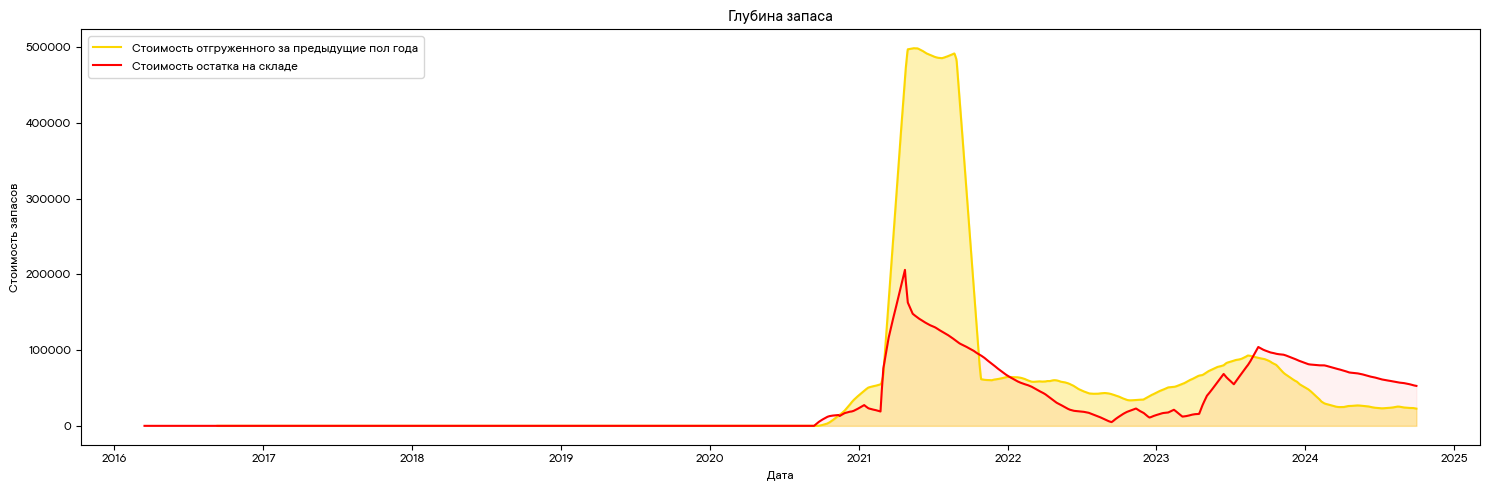

In [318]:
plt.figure(figsize=(15, 5))

# Получаем данные
cum_cost = (
    get_cumcost_shipped(df, unit=643385649, return_type="a")
    .rolling(180)
    .sum()
    .rolling(60)
    .mean()
)
total_cost_stored = get_total_cost(df, unit=643385649)["total"].rolling(60).mean()

# Строим первый график
plt.plot(
    cum_cost.index,
    cum_cost,
    label="Стоимость отгруженного за предыдущие пол года",
    color="#FCD700",
)
plt.fill_between(cum_cost.index, cum_cost, color="#FCD700", alpha=0.3)

# Строим второй график
plt.plot(
    total_cost_stored.index,
    total_cost_stored,
    label="Стоимость остатка на складе",
    color="red",
)
plt.fill_between(total_cost_stored.index, total_cost_stored, color="red", alpha=0.05)

# Настройки графика
plt.title("Глубина запаса")
plt.xlabel("Дата")
plt.ylabel("Стоимость запасов")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Диаграммы

#### Стоимость остатков по дням

Посмотрим как менялась стоимость остатков по месяцам.

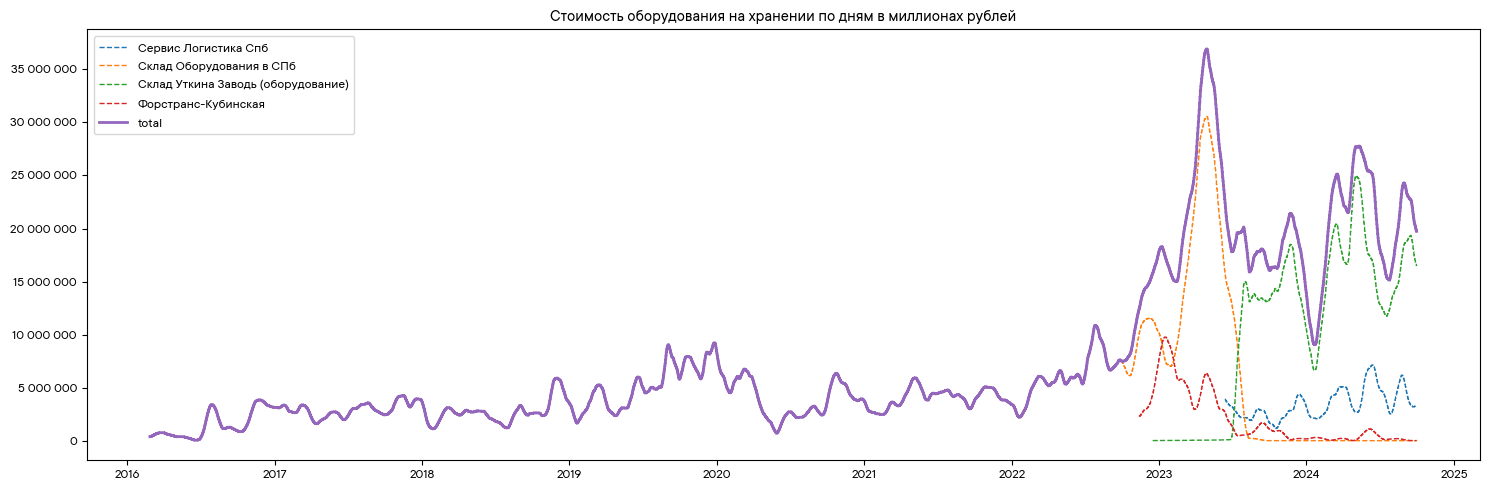

In [319]:
df_total_costs = get_total_cost(df).rolling(30, axis=0).mean()

plt.figure(figsize=(15, 5))
plt.title("Стоимость оборудования на хранении по дням в миллионах рублей")

for wh in df_total_costs.columns:
    if wh == "total":
        plt.step(
            x=df_total_costs.index,
            y=df_total_costs[[wh]].rolling(14).mean(),
            where="post",
            linewidth=2,
        )
    else:
        plt.step(
            x=df_total_costs.index,
            y=df_total_costs[[wh]].rolling(14).mean(),
            where="post",
            linewidth=1,
            linestyle="--",
        )


# Функция форматирования для оси Y
def millions(x, pos):
    return f"{int(x / 1e6)} мил."


# Применение форматирования к оси Y
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.legend(df_total_costs.columns)
plt.tight_layout()
plt.show()

### Доля стоимости затрат от общего оборота 

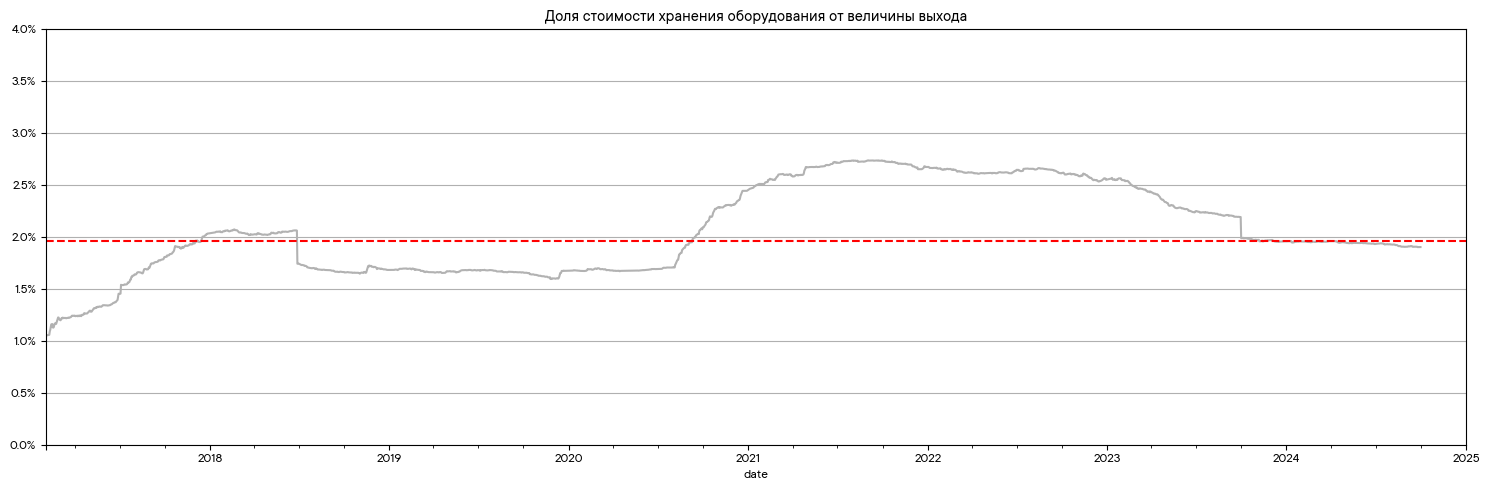

In [333]:
asd = pd.concat([get_cumcost_shipped(df), get_cumcost_stored(df)], axis=1)
asd["share"] = asd["total_stored"] / asd["total_cost"]

asd["share"].plot(figsize=(15, 5), color="#b2b2b2")
plt.axhline(y=asd["share"].median(), color="red", linestyle="--")
plt.ylim(0, 0.04)
plt.gca().set_yticklabels(["{:.1%}".format(y) for y in plt.gca().get_yticks()])
plt.title("Доля стоимости хранения оборудования от величины выхода")
plt.grid(axis="y")
plt.xlim(pd.to_datetime("2017-02-01"), pd.to_datetime("2025-01-01"))
plt.tight_layout()
plt.show()

### Доля расходов на неликвид от всех расходов

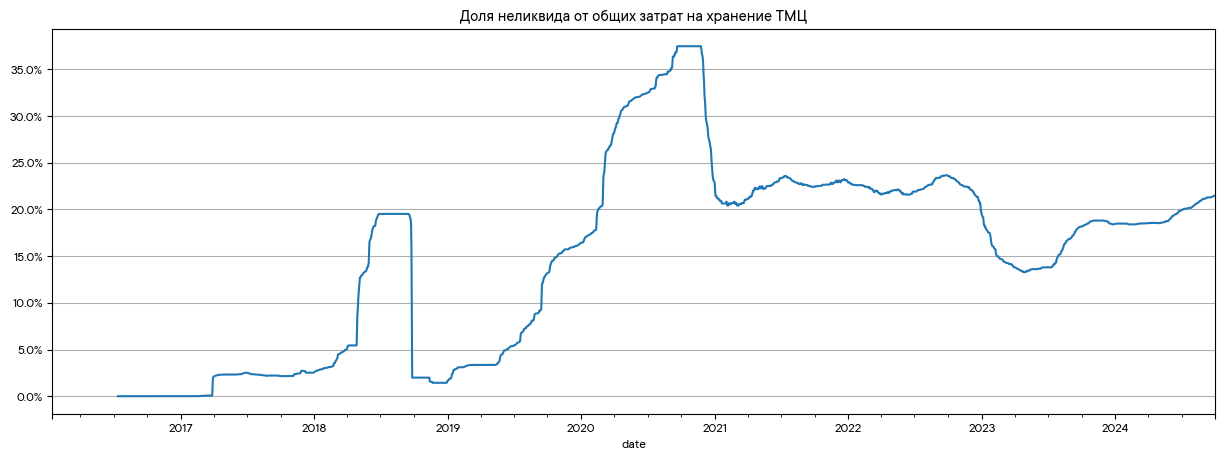

In [340]:
storage_cost_by_type["share"] = storage_cost_by_type["illiquid"] / (
    storage_cost_by_type["liquid"] + storage_cost_by_type["illiquid"]
)

storage_cost_by_type.share.rolling(180).median().plot(
    figsize=(15, 5), title="Доля неликвида от общих затрат на хранение ТМЦ"
)
plt.gca().set_yticklabels(["{:.1%}".format(y) for y in plt.gca().get_yticks()])
plt.grid(axis="y")
plt.show()

### Сумма потерь по брендам

Сумма потерь на хранении за 8 лет: 287.24 млн. руб.
Сумма потерь только на ТМЦ без движения больше 6 месяцев: 29.79 млн. руб.
Потери склада оборудования при хранении составляют 22.96% за весь период


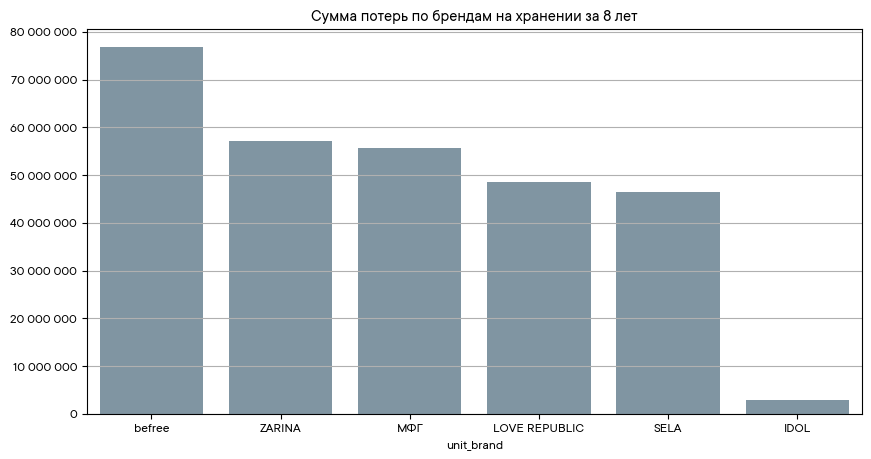

In [322]:
losses_per_brand = (
    results.query("losses > 0")
    .groupby("unit_brand")["losses"]
    .sum()
    .sort_values(ascending=False)
)

print(
    f"Сумма потерь на хранении за 8 лет: {losses_per_brand.sum() / 1000000:.2f} млн. руб."
)
print(
    f"Сумма потерь только на ТМЦ без движения больше 6 месяцев: {results['illiquid_storage_value'].sum() / 1000000:.2f} млн. руб."
)
print(
    f"Потери склада оборудования при хранении составляют {losses_per_brand.sum() / (total_cost * 12 * 8):.2%} за весь период"
)

# Построим столбчатую диаграмму
plt.figure(figsize=(10, 5))
sns.barplot(x=losses_per_brand.index, y=losses_per_brand.values, color="#7A96A8")
plt.grid(axis="y")
plt.title("Сумма потерь по брендам на хранении за 8 лет")
plt.gca().set_yticklabels(
    ["{:,.0f}".format(y).replace(",", " ") for y in plt.gca().get_yticks()]
)
plt.show()

### Показатели случайных номенклатур

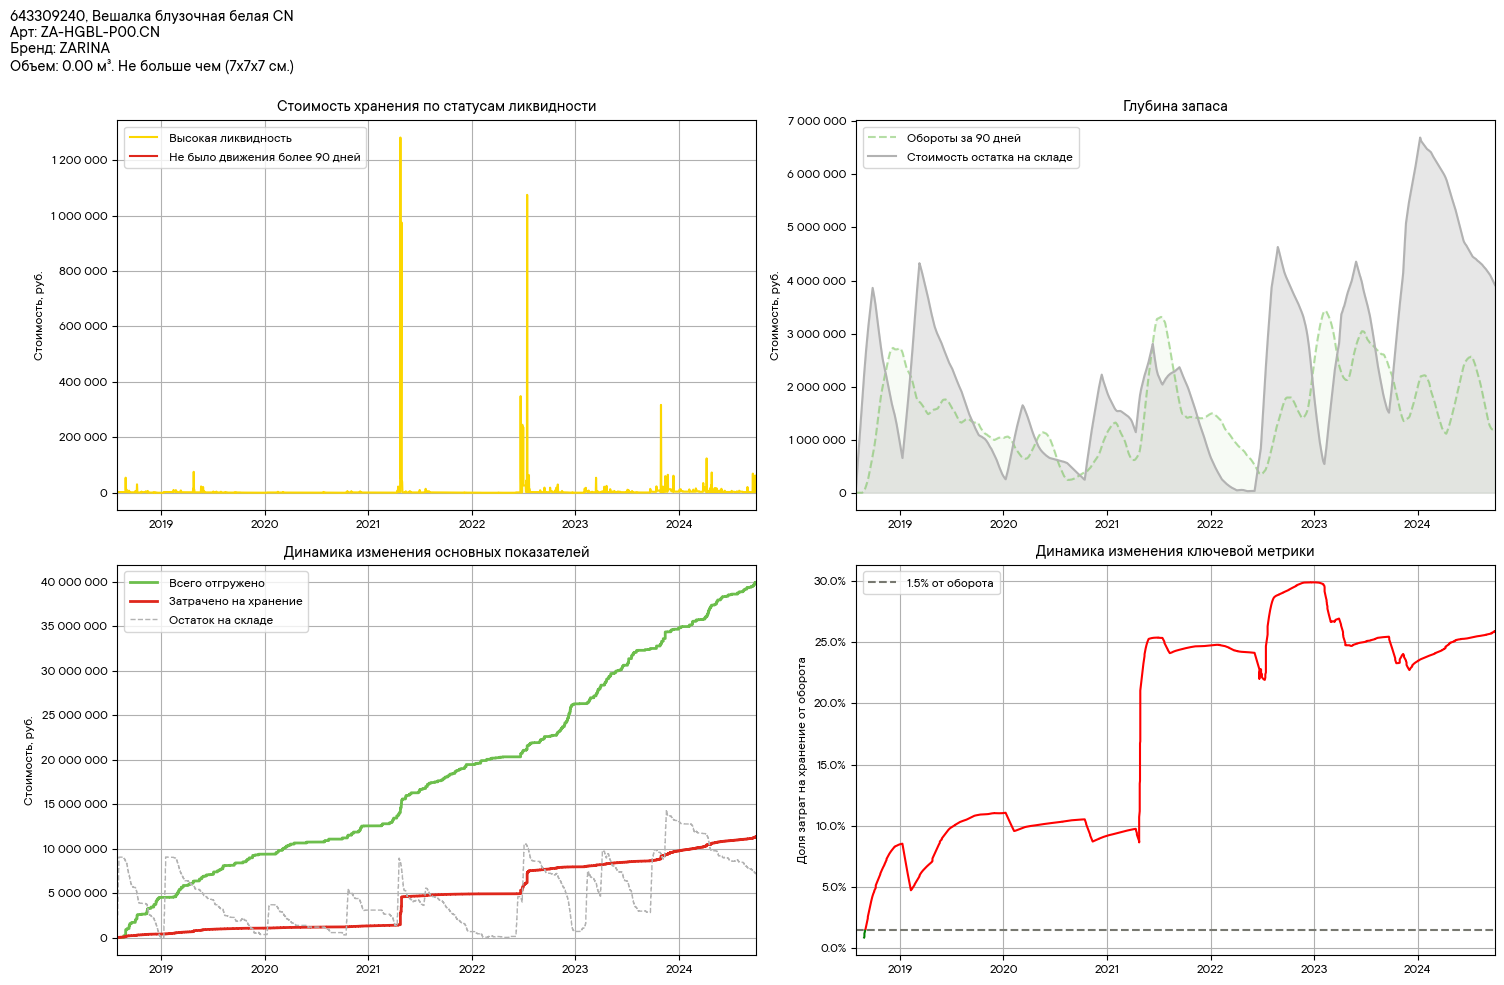

In [345]:
# Выберем случайную номенклатуру
n = random.sample(df.unit_id.unique().tolist(), 1)[0]

plot_combined(df, 643309240, level=loss_level, illiquid_days=max_dead_days)